In [1]:
using PyCall
using Debugger
using Profile
using Plots
using DifferentialEquations
using PCHIPInterpolation

#plotlyjs()

pushfirst!(pyimport("sys")."path", "")


@pyinclude("ic4elspec.py")

#to do:
#check out ODEProblemLibrary.prob_ode_rober for chemical rections
#multidimesional arrays!!
#slimmer prod: simple linear interpolation?

In [2]:
py"""
direc = "/Users/ost051/Documents/PhD/ElectronPrecipitation/log/testing/2023.05.03_14_07_04_mixf=0/"
file = "ElSpec-iqt_IC_"
iteration = 0

chemistry_config = "Data/other/Reaction rates full set.txt"

mixf = 0
"""
const a = py"ic(direc, chemistry_config, file, iteration, mixf = 0)";


# when importing Temperatures directly from Matlab:
# [ne_, Ti, Te, _] = con["par"].swapaxes(0, 1) => Ti, Te
# [Tn, Ti_, Te_, nN2, nO2, nO, nAr, nNOp, nO2p, nOp] = n_model.swapaxes(0, 1) => Tn
# Tr = (Ti + Tn) / 2
#define nh, nT, nt

ckpnt 1


In [3]:
const ts, te, n0, nprod, e_prod, temp, temp_notInterp, nh, ordering = a;

const ts_ = 0
const te_ = 1

const t_save = range(ts_, te_, 1001)

0.0:0.001:1.0

In [4]:
temp_int = Array{Any}(undef, size(temp_notInterp)[1:2])
for i in 1:size(temp_notInterp)[1]
    for j in 1:size(temp_notInterp)[2]
        temp_int[i, j] = Interpolator(ts, temp_notInterp[i, j, :])
    end
end

const temp_int_c = temp_int

function temp_julia(t)
    return [temp_int_c[i, j](t) for i in 1:size(temp_notInterp)[1], j in 1:size(temp_notInterp)[2]]
end



const temp_int2 = (Interpolator(ts, temp_notInterp[i, j, :]) for i in 1:size(temp_notInterp)[1], j in 1:size(temp_notInterp)[2])
function temp_julia3(t)
    return (i(t) for i in temp_int2)
end


function temp_julia4(t, temp_int2)
    next = Iterators.take(temp_int2, 3)
    while next !== nothing
        (item, state) = next
        [i(t) for i in item]
        next = iterate(Iterators.take(temp_int2, 3), state)
    end
end


temp_julia4 (generic function with 1 method)

In [5]:
@time temp_julia(0);
@time temp_julia(0);

  0.026473 seconds (40.30 k allocations: 2.650 MiB, 99.22% compilation time)
  0.000037 seconds (190 allocations: 4.625 KiB)


In [181]:
@time collect(temp_julia3(0));
@time begin
    b = Matrix{Float64}(undef, (3, 62))
    b.= temp_julia3(0)
end
b


  0.001953 seconds (2.05 k allocations: 7.034 MiB)
  0.001745 seconds (2.05 k allocations: 7.036 MiB)


3×62 Matrix{Float64}:
 187.334  186.291  185.71   185.666  …  646.215  652.512  658.666  664.679
 231.987  226.013  217.551  201.504     894.192  862.69   825.218  783.135
 259.466  252.819  243.183  224.752     735.903  749.782  763.811  778.004

In [23]:
include("juliaIC.jl");
const path_reactions_file = "/Users/ost051/Documents/PhD/ElectronPrecipitation/Data/other/Reaction rates full set ext.txt"
const dndt, particles, reactions, ode_raw = juliaIC.initIC(path_reactions_file, ordering)
particles

19-element Vector{Vector{Any}}:
 [1, "e-"]
 [2, "O"]
 [3, "O2"]
 [4, "O2+"]
 [5, "N+"]
 [6, "N2"]
 [7, "N2+"]
 [8, "NO"]
 [9, "NO+"]
 [10, "H"]
 [11, "H+"]
 [12, "O(1D)"]
 [13, "O(1S)"]
 [14, "N(2D)"]
 [15, "N(4S)"]
 [16, "O2+(a4P)"]
 [17, "O+(2D)"]
 [18, "O+(4S)"]
 [19, "O+(2P)"]

In [24]:
function stepf(prod, t, ts, te)
    if t.<ts[1] return 0
    elseif t.>te[end] return 0
    else
        i_max_ts = length(ts[ts .<= t])
        return prod[i_max_ts]
    end
end

const t_step = range(ts[1], te[end], step=1e-2)

const e_prod_step = [stepf(e_prod[i, :], t, ts, te) for i in 1:size(e_prod)[1], t in t_step]

const itp = [Interpolator(t_step, e_prod_step[i, :]) for i in 1:size(e_prod_step)[1]];

In [25]:
function e_prod_f(t, itp)
    return (i.(t) for i in itp)
end

println(size(e_prod_f(0, itp)))

function zerof(t)
    return zeros(62)
end

(62,)


zerof (generic function with 1 method)

In [26]:
nprod_julia = Array{Any}(undef, length(particles))
nprod_julia.= zerof


i_O  = findall(p -> p[2] == "O", particles)[1]
i_O2 = findall(p -> p[2] == "O2", particles)[1]
i_N2 = findall(p -> p[2] == "N2", particles)[1]
for i in 1:length(particles)
    if particles[i][2] == "e-"
        nprod_julia[i] = (t) -> e_prod_f(t, itp)
    end
    if particles[i][2] == "O+(4S)"
        nprod_julia[i] = (t) -> e_prod_f(t, itp) .* n0[i_O , :]*0.56 ./(n0[i_O, :]*0.56 .+ n0[i_N2, :]*0.92 .+ n0[i_O2, :])
        println(size(nprod_julia[i](0)))
    end
    if particles[i][2] == "O2+"
        nprod_julia[i] = (t) -> e_prod_f(t, itp) .* n0[i_N2, :]*0.92 ./(n0[i_O, :]*0.56 .+ n0[i_N2, :]*0.92 .+ n0[i_O2, :])
    end
    if particles[i][2] == "N2+"
        nprod_julia[i] = (t) -> e_prod_f(t, itp) .* n0[i_O2, :]      ./(n0[i_O, :]*0.56 .+ n0[i_N2, :]*0.92 .+ n0[i_O2, :])
    end
end

const nprod_julia_c = nprod_julia


(62,)


19-element Vector{Any}:
 #23 (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 #25 (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 #26 (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 #24 (generic function with 1 method)
 zerof (generic function with 1 method)

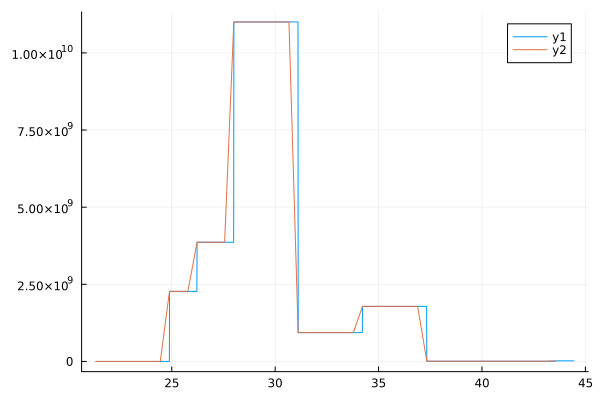

In [27]:
plot!(range(ts[50],te[100],step=1e-2), [stepf(e_prod[1, :], t, ts, te) for t in range(ts[50],te[100],step=1e-2)])
plot!(ts[50:100], e_prod[1, 50:100])


In [42]:
c = "asdf"
typeof(c)

String

In [156]:

#ode_raw = juliaIC.ode_raw

function dndtFromString(s)
    f = eval(Meta.parse("(nprodd, r, rr, tt) -> " * s))
    return (nprodd, r, rr, tt) -> Base.invokelatest(f, nprodd, r, rr, tt)
end


dndt = Array{Any}(undef, length(particles))
dndt_str = Array{String}(undef, length(particles))

for i in 1:length(particles)
    #dndt_str = ""
    if ode_raw[i] == [0]
        dndt_str[i] = "zeros(size(rr[1]))"
        #print(particles[i][2], "\n") #all species that are assumed of constant density (N2, O2, O, H)
    else
        #print(ode_raw[i], "\n")
        dndt_str[i] = "nprodd[$i](tt)"
        for o in ode_raw[i]
            if o == [0] #if not participating in reaction, no terms are added
            else
                #print(o, "\n")
                dndt_str[i] = dndt_str[i] * " .+ $(o[2]).* rr[$(o[1])]"
                #dndt_str[i] = dndt_str[i] * " \n .+ $(o[2]).* $(reactions_[o[1]][2])"
                
            end
        end
    end
    #println(dndt_str[i], "\n")
end

for i in 1:length(particles)
    dndt[i] = dndtFromString(dndt_str[i])
end

const dndt_c = dndt

dndt2 = Array{Any}(undef, length(particles))
dndt_str2 = Array{String}(undef, length(particles))

for i in 1:length(particles)
    #dndt_str = ""
    if ode_raw[i] == [0]
        dndt_str2[i] = "zeros(size(rr[1]))"
        #print(particles[i][2], "\n") #all species that are assumed of constant density (N2, O2, O, H)
    else
        #print(ode_raw[i], "\n")
        dndt_str2[i] = "nprodd[$i](tt)"
        for o in ode_raw[i]
            if o == [0] #if not participating in reaction, no terms are added
            else
                #print(o, "\n")
                dndt_str2[i] = dndt_str2[i] * " .+ $(o[2]).* rr[:, $(o[1])]"
                #dndt_str[i] = dndt_str[i] * " \n .+ $(o[2]).* $(reactions_[o[1]][2])"
                
            end
        end
    end
    #println(dndt_str[i], "\n")
end

for i in 1:length(particles)
    dndt2[i] = dndtFromString(dndt_str2[i])
end

const dndt_c2 = dndt2

function dummyf(n, p, t)
    dn = zeros(size(n))
    reactions, nprod, dndt, temp = p
    temp_ = collect(temp(t))
    temp_2 = [temp_[i, :] for i in 1:size(temp_,1)]
    
    #is quite slow! try to get rid of loops
    
    rr = [r[4](temp_2) for r in reactions]
  
    for (i, r) in enumerate(reactions)
        for j in r[2]
            rr[i] = rr[i].*n[j, :]
        end
    end
        
    for j in 1:size(n)[1]
        #dn[j, :] .= nprod[j](t)
        dn[j, :] .= dndt[j](nprod, reactions, rr, t)
    end 
    return dn
end



function dummyf2(dn::Matrix{Float64}, n, p, t)
    #dn = zeros(size(n))
    reactions, nprod, dndt, temp = p
    temp_ = collect(temp(t))
    temp_2 = [temp_[i, :] for i in 1:size(temp_,1)]
    
    #is quite slow! try to get rid of loops
    
    rr = [r[4](temp_2) for r in reactions]
  
    for (i, r) in enumerate(reactions)
        for j in r[2]
            rr[i] = rr[i].*n[j, :]
        end
    end
        
    for j in 1:size(n)[1]
        #dn[j, :] .= nprod[j](t)
        dn[j, :] .= dndt[j](nprod, reactions, rr, t)
    end 
    nothing;
#    return dn
end

function dummyf3(n, p, t)
    dn = zeros(size(n))
    reactions, nprod, dndt, temp = p
    
    rr = Matrix{Float64}(undef, (62, 52))
    rr.= [j[4](i) for i in eachrow(temp(0)'), j in reactions]
    
    for (i, r) in enumerate(reactions)
        for j in r[2]
            rr[:, i] = rr[:, i].*n[j, :]
        end
    end
        
    for j in 1:size(n)[1]
        #dn[j, :] .= nprod[j](t)
        dn[j, :] .= dndt2[j](nprod, reactions, rr, t)
    end 
    return dn
end

dummyf3 (generic function with 1 method)

In [145]:
temp_ = collect(temp_julia(0))
temp_2 = [temp_[i, :] for i in 1:size(temp_,1)]
rr = [r[4](temp_2) for r in reactions]

#rr =  Vector{Vector{Float64}}(undef, )
@time begin
rr = Matrix{Float64}(undef, (62, 52))
rr = [j[4](i) for i in eachrow(temp_julia(0)'), j in reactions]
end

@time cc = [j[4](i) for i in eachrow(temp_julia(0)'), j in reactions]


  0.032468 seconds (100.92 k allocations: 5.708 MiB, 93.92% compilation time)
  0.150738 seconds (100.92 k allocations: 5.683 MiB, 77.99% gc time, 98.93% compilation time)


62×52 Matrix{Float64}:
 2.40439e-13  2.16286e-13  6.26726e-13  …  0.0001  1.215  0.07601  0.00745
 2.41112e-13  2.16758e-13  6.29709e-13     0.0001  1.215  0.07601  0.00745
 2.41488e-13  2.17022e-13  6.31381e-13     0.0001  1.215  0.07601  0.00745
 2.41517e-13  2.17042e-13  6.3151e-13      0.0001  1.215  0.07601  0.00745
 2.41146e-13  2.16782e-13  6.29861e-13     0.0001  1.215  0.07601  0.00745
 2.4032e-13   2.16203e-13  6.26199e-13  …  0.0001  1.215  0.07601  0.00745
 2.39018e-13  2.15288e-13  6.2044e-13      0.0001  1.215  0.07601  0.00745
 2.37278e-13  2.14065e-13  6.1278e-13      0.0001  1.215  0.07601  0.00745
 2.35144e-13  2.12561e-13  6.03441e-13     0.0001  1.215  0.07601  0.00745
 2.32659e-13  2.10808e-13  5.92643e-13     0.0001  1.215  0.07601  0.00745
 2.29869e-13  2.08833e-13  5.80609e-13  …  0.0001  1.215  0.07601  0.00745
 2.26815e-13  2.06666e-13  5.6756e-13      0.0001  1.215  0.07601  0.00745
 2.23545e-13  2.04338e-13  5.53719e-13     0.0001  1.215  0.07601  0.00745
 ⋮

In [101]:
println(reactions[1][4](temp(0)))
println(size(temp_julia3(0)))

@time collect(j[4](i) for i in eachrow(temp(0)'), j in reactions)
@time collect(j[4](i) for i in eachrow(temp(0)'), j in reactions)
@time collect(j[4](i) for i in eachrow(collect(temp_julia(0))'), j in reactions)
@time collect(j[4](i) for i in eachrow(collect(temp_julia(0))'), j in reactions)
@time collect(j[4](i) for i in eachrow(collect(temp_julia3(0))'), j in reactions)
@time collect(j[4](i) for i in eachrow(collect(temp_julia3(0))'), j in reactions)





2.4043946885773026e-13
(3, 62)
  0.047104 seconds (100.77 k allocations: 5.935 MiB, 96.18% compilation time)
  0.030824 seconds (100.77 k allocations: 5.686 MiB, 94.63% compilation time)
  0.028283 seconds (100.92 k allocations: 5.694 MiB, 94.51% compilation time)
  0.028003 seconds (100.92 k allocations: 5.747 MiB, 94.68% compilation time)
  0.033600 seconds (102.77 k allocations: 12.713 MiB, 87.42% compilation time)
  0.030777 seconds (102.77 k allocations: 12.713 MiB, 89.14% compilation time)


62×52 Matrix{Float64}:
 2.40439e-13  2.16286e-13  6.26726e-13  …  0.0001  1.215  0.07601  0.00745
 2.41112e-13  2.16758e-13  6.29709e-13     0.0001  1.215  0.07601  0.00745
 2.41488e-13  2.17022e-13  6.31381e-13     0.0001  1.215  0.07601  0.00745
 2.41517e-13  2.17042e-13  6.3151e-13      0.0001  1.215  0.07601  0.00745
 2.41146e-13  2.16782e-13  6.29861e-13     0.0001  1.215  0.07601  0.00745
 2.4032e-13   2.16203e-13  6.26199e-13  …  0.0001  1.215  0.07601  0.00745
 2.39018e-13  2.15288e-13  6.2044e-13      0.0001  1.215  0.07601  0.00745
 2.37278e-13  2.14065e-13  6.1278e-13      0.0001  1.215  0.07601  0.00745
 2.35144e-13  2.12561e-13  6.03441e-13     0.0001  1.215  0.07601  0.00745
 2.32659e-13  2.10808e-13  5.92643e-13     0.0001  1.215  0.07601  0.00745
 2.29869e-13  2.08833e-13  5.80609e-13  …  0.0001  1.215  0.07601  0.00745
 2.26815e-13  2.06666e-13  5.6756e-13      0.0001  1.215  0.07601  0.00745
 2.23545e-13  2.04338e-13  5.53719e-13     0.0001  1.215  0.07601  0.00745
 ⋮

In [158]:
@time dummyf3(n0, (reactions, nprod, dndt, temp), 0);
@time dummyf3(n0, (reactions, nprod, dndt, temp), 0);

@time dummyf(n0, (reactions, nprod, dndt, temp), 0);
@time dummyf(n0, (reactions, nprod, dndt, temp), 0);


@time dummyf(n0, (reactions, nprod_julia, dndt, temp), 0);
@time dummyf(n0, (reactions, nprod_julia, dndt, temp), 0);

@time dummyf(n0, (reactions, nprod_julia, dndt_c, temp), 0);
@time dummyf(n0, (reactions, nprod_julia, dndt_c, temp), 0);

@time dummyf(n0, (reactions, nprod_julia, dndt_c, temp_julia), 0);
@time dummyf(n0, (reactions, nprod_julia, dndt_c, temp_julia), 0);

dn = Matrix{Float64}(undef, size(n0))
@time dummyf2(dn, n0, (reactions, nprod_julia, dndt_c, temp_julia), 0);
dn = Matrix{Float64}(undef, size(n0))
@time dummyf2(dn, n0, (reactions, nprod_julia, dndt_c, temp_julia), 0);

  0.049833 seconds (44.40 k allocations: 2.059 MiB)
  0.003377 seconds (44.40 k allocations: 2.059 MiB)
  0.002890 seconds (2.39 k allocations: 342.781 KiB)
  0.000813 seconds (2.39 k allocations: 342.781 KiB)
  0.001904 seconds (1.89 k allocations: 332.688 KiB)
  0.000499 seconds (1.89 k allocations: 332.688 KiB)
  0.000500 seconds (1.89 k allocations: 332.688 KiB)
  0.000478 seconds (1.89 k allocations: 332.688 KiB)
  0.001320 seconds (2.03 k allocations: 333.734 KiB)
  0.000749 seconds (2.03 k allocations: 333.734 KiB)
  0.000785 seconds (2.03 k allocations: 324.359 KiB)
  0.000660 seconds (2.03 k allocations: 324.359 KiB)


In [161]:
function solveIC_allAtOnce(n0, ts, te, nprod, temp, reactions, dndt)
    tspan = (ts, te)
    prob = ODEProblem(dummyf, n0, tspan, (reactions, nprod, dndt, temp))
    sol = solve(prob, TRBDF2(autodiff=false), reltol = 1e-7, abstol = 1e-3, saveat = t_save)
    return sol    
end

solveIC_allAtOnce (generic function with 1 method)

In [162]:
@time sol3 = solveIC_allAtOnce(n0, ts_, te_, nprod, temp, reactions, dndt);

 75.309398 seconds (398.74 M allocations: 483.178 GiB, 10.69% gc time, 0.89% compilation time: 58% of which was recompilation)


In [163]:
@time sol3 = solveIC_allAtOnce(n0, ts_, te_, nprod_julia_c, temp_julia, reactions, dndt_c);

 70.829902 seconds (421.79 M allocations: 545.117 GiB, 10.06% gc time, 0.93% compilation time: 67% of which was recompilation)


In [ ]:
@time sol3 = solveIC_allAtOnce(n0, ts_, te_, nprod_julia, temp_julia3, reactions, dndt);

In [ ]:
sol1[1]

In [43]:
@time sol1 = juliaIC.solveIC(n0, ts_, te_, nprod, temp, t_save, reactions, dndt);

LoadError: MethodError: no method matching (::var"#33#34"{var"#35#36"})(::Vector{PyObject}, ::Vector{Any}, ::Vector{Vector{Float64}}, ::Vector{Float64}, ::Float64)

[0mClosest candidates are:
[0m  (::var"#33#34")(::Any, ::Any, ::Any, ::Any)
[0m[90m   @[39m [33mMain[39m [90m[4mIn[28]:6[24m[39m


In [148]:
@time sol1 = juliaIC.solveIC(n0, ts_, te_, nprod_julia, temp_julia, t_save, reactions, dndt);

LoadError: MethodError: no method matching (::var"#587#588"{var"#589#590"})(::Vector{Any}, ::Vector{Any}, ::Vector{Vector{Float64}}, ::Vector{Float64}, ::Float64)

[0mClosest candidates are:
[0m  (::var"#587#588")(::Any, ::Any, ::Any, ::Any)
[0m[90m   @[39m [33mMain[39m [90m[4mIn[139]:6[24m[39m


In [147]:
@time sol2 = juliaIC.solveIC_allAtOnce(n0, ts_, te_, nprod_julia, temp_julia, t_save, reactions, dndt);

LoadError: MethodError: no method matching (::var"#587#588"{var"#589#590"})(::Vector{Any}, ::Vector{Any}, ::Vector{Vector{Float64}}, ::Matrix{Float64}, ::Float64)

[0mClosest candidates are:
[0m  (::var"#587#588")(::Any, ::Any, ::Any, ::Any)
[0m[90m   @[39m [33mMain[39m [90m[4mIn[139]:6[24m[39m


In [ ]:
@time sol2 = juliaIC.solveIC_allAtOnce(n0, ts_, te_, nprod_julia, temp, t_save, reactions, dndt);

In [ ]:
@time sol2 = juliaIC.solveIC_allAtOnce(n0, ts_, te_, nprod, temp, t_save, reactions, dndt)

In [42]:
nprod[1](0)


62-element Vector{Float64}:
 2.3468991949894056e8
 5.758440256754757e8
 1.1762670274161274e9
 2.0632307596038108e9
 3.1908779291868963e9
 4.449653619828161e9
 5.703248308997093e9
 6.83143210435948e9
 7.754219893024414e9
 8.436716716422884e9
 8.880838041384436e9
 9.112101151850105e9
 9.16731682239053e9
 ⋮
 2.0364942494259312e9
 1.9781109164034536e9
 1.9226897733109682e9
 1.8700706722988176e9
 1.8201138315081062e9
 1.7726958270275946e9
 1.727692267644037e9
 1.684923057877791e9
 1.6439898289946795e9
 1.6038644929862013e9
 1.5622421600018065e9
 1.515393459930683e9

In [57]:
nprod_julia

19-element Vector{Any}:
 #49 (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 #51 (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 #52 (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 zerof (generic function with 1 method)
 #50 (generic function with 1 method)
 zerof (generic function with 1 method)

In [58]:
println(size(sol1))
println([size(h) for h in sol1])

sol1u = zeros(size(sol2.u))

println(size(sol2.u))
println(size(sol3.u))
maximum([maximum(u[:]) for u in (sol2.u - sol3.u)./sol3.u])

LoadError: UndefVarError: `sol1` not defined

In [59]:
#temp(t)[ts, h, [Tn, Ti, Te]]
#println(size(ts))
#println(size(temp(ts)))
temp_ = temp(ts)
temp_2 = [temp_[i, :] for i in 1:size(temp_,1)]
#println(typeof(temp_2))
println(size(temp_2[1]))

for i in 1:length(particles)
    print(i, " ")
    #println(dndt[i])
    println(size(dndt[i](nprod, reactions, temp_2, n0, 0.1)))
    println(dndt[i](nprod, reactions, temp_2, n0, ts))
end
println("chkpnt2")

LoadError: BoundsError: attempt to access 675×3×62 Array{Float64, 3} at index [1, 1:3]

In [60]:


function dummyf(n, p, t)
    dn = zeros(size(n))
    reactions, nprod, dndt, temp = p
    temp_ = temp(t)
    temp_2 = [temp_[i, :] for i in 1:size(temp_,1)]
    
    rr = [r[4](temp_2) for r in reactions]
    
    for j in 1:size(n)[1]
        #dn[j, :] .= nprod[j](t)
        dn[j, :] .= dndt[j](nprod, reactions, temp_2, n, t)
    end 
    return dn
end


tspan = (0, 1)dd
prob = ODEProblem(dummyf, n0, tspan, (reactions, nprod, dndt, temp))
#sol = solve(prob, SciPyDiffEq.BDF(), reltol = 1e-7, abstol = 1e-3)

#dummyf(u0, (reactions, nprod, dndt, temp), 0)


sol = solve(prob, TRBDF2(autodiff=false), reltol = 1e-7, abstol = 1e-3)

LoadError: UndefVarError: `dd` not defined

In [61]:
[m[m .< 0] for m in sol.u]

LoadError: UndefVarError: `sol` not defined

In [62]:
p = plot(sol1[1],
    xaxis = "Time (t)",
    yaxis = ("u(t) (in μm)"),
    label = reshape([p[2] for p in particles], (1, :)),
    )#ylimits = (1, 1e12))


LoadError: UndefVarError: `sol1` not defined

In [63]:
sol[1]

p = plot(sol[1], 
     xaxis = "Time (t)", yaxis = ("u(t) (in μm)", :log), label = reshape([p[2] for p in particles], (1, :)), 
        ylimits = (1, 1e12))
#plot!(sol.t, t -> 0.5 * exp(1.01t), lw = 3, ls = :dash, label = "True Solution!")
#display(p)

LoadError: UndefVarError: `sol` not defined

In [64]:
sol1[1]

LoadError: UndefVarError: `sol1` not defined